<a href="https://colab.research.google.com/github/navervision/KELIP/blob/master/notebooks/Interacting_with_KELIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KELIP: Large-scale Bilingual Language-Image Contrastive Learning

[![arXiv](https://img.shields.io/badge/arXiv-Paper-<COLOR>.svg)](https://arxiv.org/abs/2203.14463)
[![GitHub Stars](https://img.shields.io/github/stars/navervision/KELIP?style=social)](https://github.com/navervision/KELIP)
[![GitHub Forks](https://img.shields.io/github/forks/navervision/KELIP?style=social)](https://github.com/navervision/KELIP)

Welcome to the notebook for KELIP. We'll show how to use pre-trained KELIP model. We follow [CLIP's notebook](https://github.com/openai/CLIP/blob/main/notebooks/Interacting_with_CLIP.ipynb) for the codebase and examples.

## Environment setting
KELIP support both GPU and CPU environment. To use GPU in Colab, select "GPU" as the hardware accelerator in Runtime -> Change Runtime Type in the menu. Now, we are going to install KELIP package and Korean font environment.

In [4]:
! pip install git+https://github.com/navervision/KELIP.git

  Cloning https://github.com/navervision/KELIP.git to /tmp/pip-req-build-14y37ruv
  Running command git clone -q https://github.com/navervision/KELIP.git /tmp/pip-req-build-14y37ruv


In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 60 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 31 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


## Load model
Load pre-trained KELIP model. Currently, we support only 'ViT-B/32' based model.

In [5]:
import kelip
import torch
import numpy as np
from PIL import Image
from urllib.request import urlretrieve

device = "cuda" if torch.cuda.is_available() else "cpu"

model, preprocess_img, tokenizer = kelip.build_model('ViT-B/32')
model = model.to(device)
model.eval()

input_resolution = model.model.visual.input_resolution
context_length = model.model.context_length
vocab_size = model.model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 176,575,233
Input resolution: 224
Context length: 77
Vocab size: 98818


## Image preprocessing
Image preprocessing contains resizing image resolution, center cropping and pixel intensity normalization. This will be used as the input to the visual encoder.

In [6]:
preprocess_img

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_to_rgb at 0x7f4ddf3158c0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

## Text preprocessing
Input text has to be tokenized before feeding to the model. We use a case-insensitive BPE tokenizer, supporting both Korean and English. `tokenizer.encode()` returns tokenized sequences of the input texts, which are padded to become 77 tokens long.

In [7]:
text_input = ['a cute puppy', '예의바른 고양이']
tokenizer.encode(text_input)

tensor([[98816,   231,  4360, 14503, 98817,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [98816, 45488, 10916,  5438, 98817,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0, 

## Setting up input images and texts
We are going to use 8 image and text pairs (4 English and 4 Korean) and compare the similarity between the corresponding features.

In [8]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "차고에 서 있는 빨간 오토바이",
    "camera": "삼각대에서 카메라를 보는 사람",
    "horse": "말의 흑백 실루엣", 
    "coffee": "받침접시에 담긴 커피 한 잔"
}

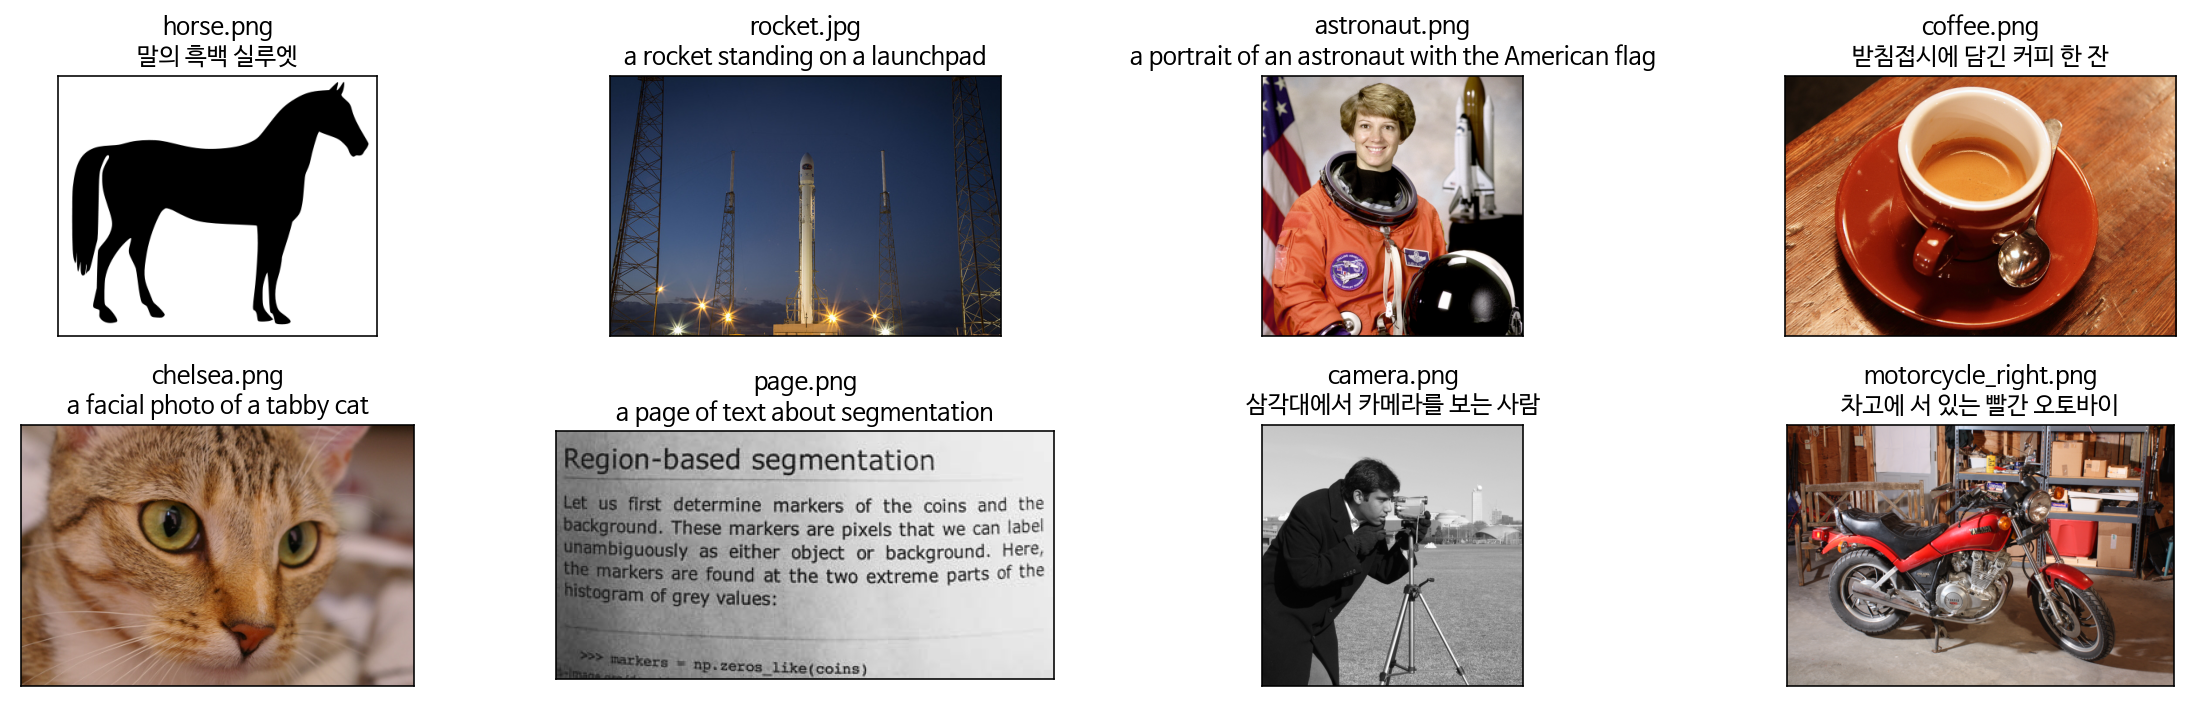

In [9]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")
  
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess_img(image))
    texts.append(descriptions[name])

plt.tight_layout()


## Extract features and compute similarity
Now, we extract image and text features from the preprocessed images and tokenized texts. The extracted features are L2 normalized by `l2norm=True` argument below. Cosine similarity between image and text features can be computed by dot product.

In [10]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = tokenizer.encode(texts).cuda()

with torch.no_grad():
    image_features = model.encode_image(image_input, l2norm=True)
    text_features = model.encode_text(text_tokens, l2norm=True)

similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

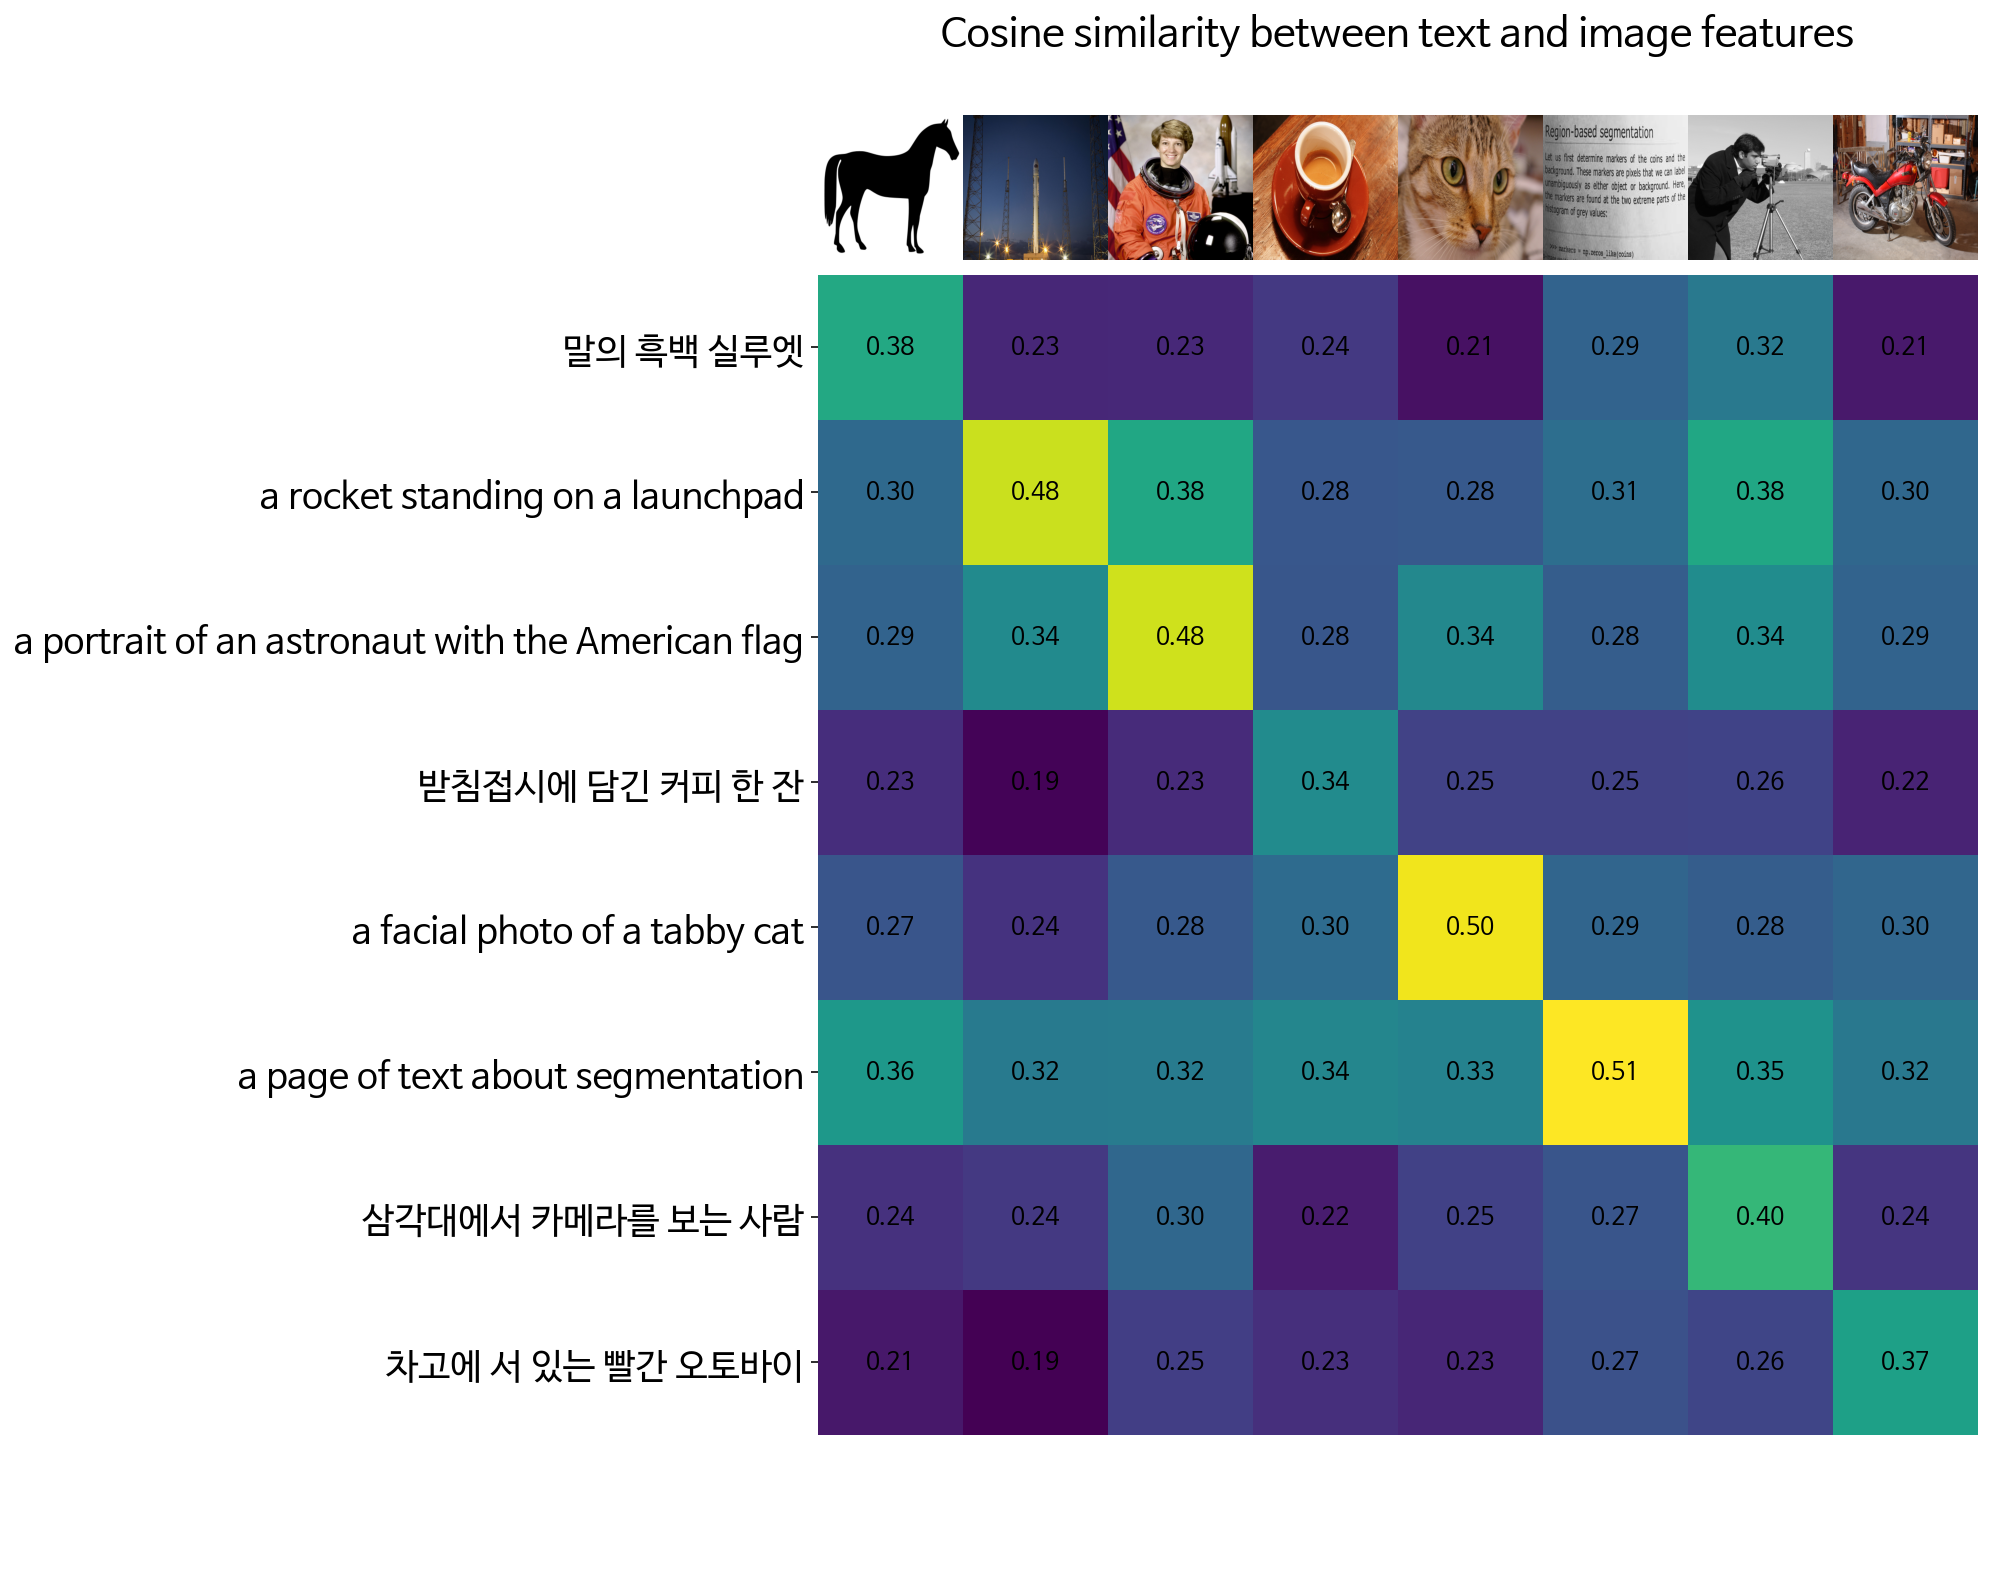

In [11]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=similarity.min(), vmax=similarity.max())
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

## Zero-shot image classification
You can perform zero-shot image classification with the cosine similarity (times `logit_scale.exp()`)as the logits to the softmax operation.

In [13]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess_img, download=True)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


In [16]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = tokenizer.encode(text_descriptions).cuda()

with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

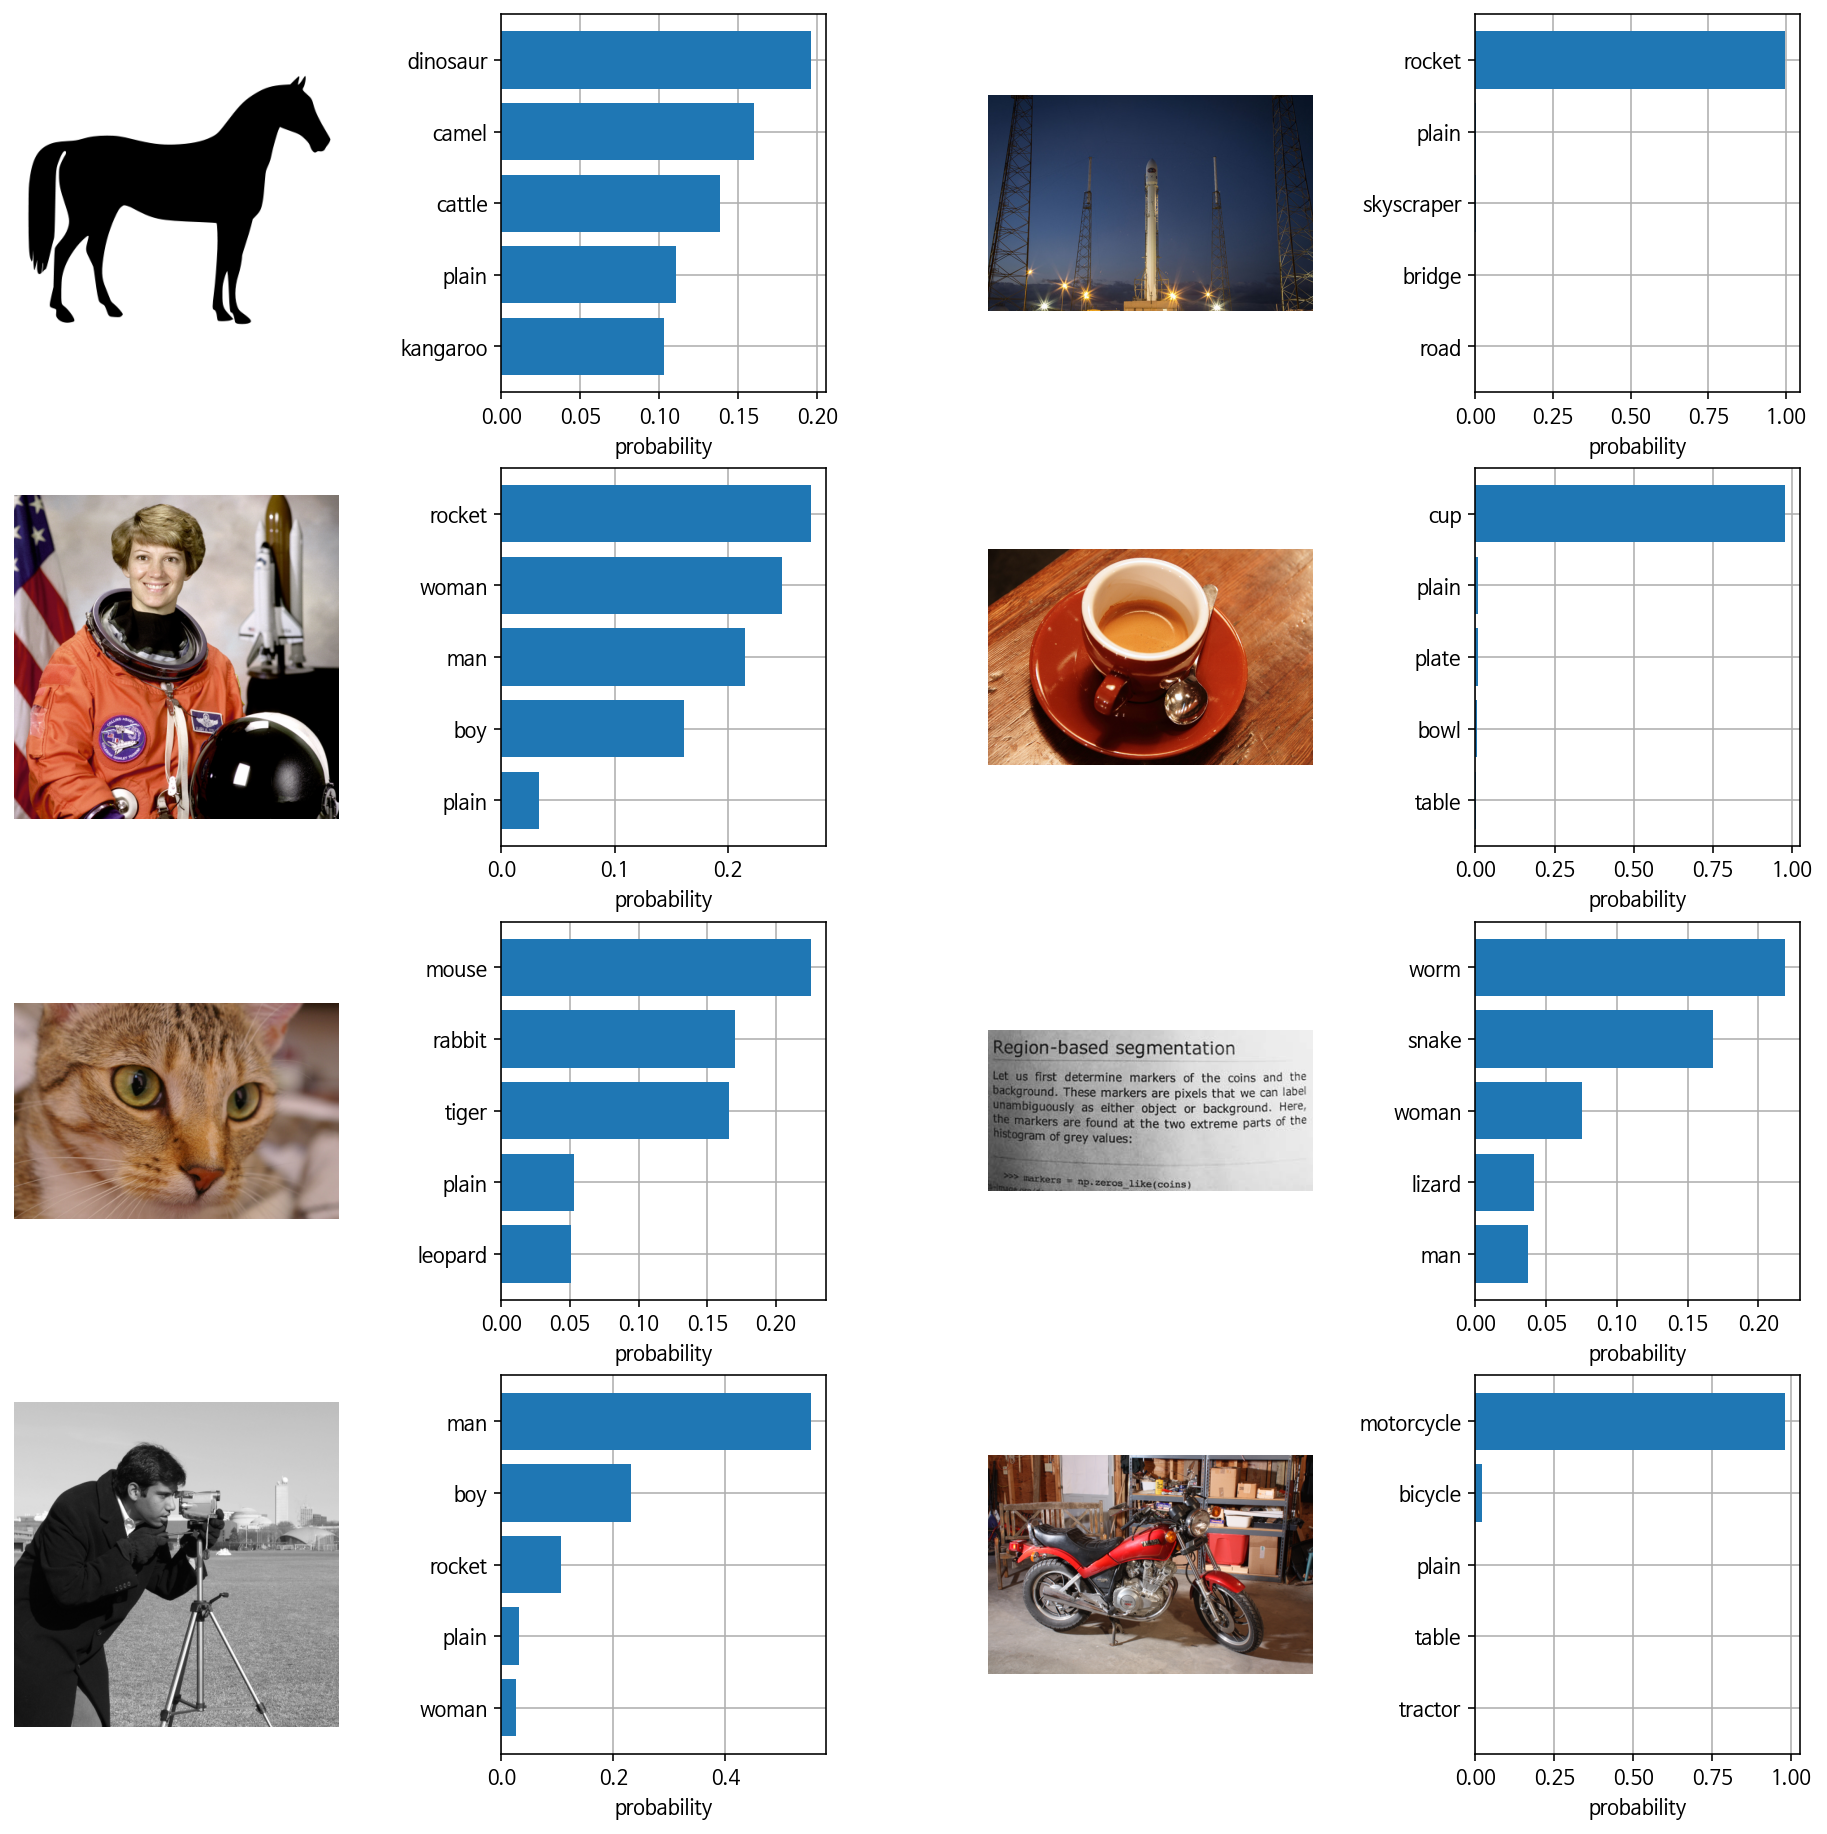

In [17]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()